In [11]:
import torch
import random
import numpy as np  # numpy
import torch.nn as nn  # nn objects
import torch.optim as optim  # nn optimizers
import matplotlib.pyplot as plt

# Set device to gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
Generates a data sample (i.e. matrix) filled with n (n = seqlen1 + seqlen2 + 2) 
vectors of size input_size. The sample contains 2 non-distraction vectors (i.e. 
"input vectors") located at input1_location and input2_location and the rest of
the sample contains "distraction vectors" (i.e. random vectors filled with
numbers between 0 and 1) located everywhere else. Depending on the sequence
type, the generated sample will have equivalent or different non-distraction
vectors
"""
def generate_sample(sequence_type, input_size, seqlen1, seqlen2, seqlen3):
    sequence_length = 2 + seqlen1 + seqlen2 + seqlen3
    X_sample = torch.zeros(sequence_length, input_size)
    Y_sample = 0
    X0 = torch.tensor(np.eye(input_size)[0])
    X1 = torch.tensor(np.eye(input_size)[1])

    # input vectors
    if sequence_type == 0:
        X_sample[seqlen1] = X0
        X_sample[seqlen1 + seqlen2 + 1] = X0
        Y_sample = [0]
    if sequence_type == 1:
        X_sample[seqlen1] = X0
        X_sample[seqlen1 + seqlen2 + 1] = X1
        Y_sample = [1]
    if sequence_type == 2:
        X_sample[seqlen1] = X1
        X_sample[seqlen1 + seqlen2 + 1] = X1
        Y_sample = [0]
    if sequence_type == 3:
        X_sample[seqlen1] = X1
        X_sample[seqlen1 + seqlen2 + 1] = X0
        Y_sample = [1]

    # distraction vectors
    for i in range(sequence_length):
        if i != seqlen1 and i != (seqlen1 + seqlen2 + 1):
            X_sample[i] = torch.rand(input_size)

    return X_sample, Y_sample

"""
Generates a dataset of 4 different versions of the XOR problem based on the
matricies made with the generate_sample function. This dataset will contain
the equivalent of matricies corresponding to the [0, 0, 0], [0, 1, 1], 
[1, 1, 0], and [1, 0, 1] examples of the XOR problem in that order
"""
def generate_dataset(same_distractions, input_size, seqlen1, seqlen2, seqlen3):
    sequence_length = 2 + seqlen1 + seqlen2 + seqlen3
    dataset = torch.zeros(4, sequence_length, input_size)
    dataset[0], YA = generate_sample(0, input_size, seqlen1, seqlen2, seqlen3)
    dataset[1], YB = generate_sample(1, input_size, seqlen1, seqlen2, seqlen3)
    dataset[2], YA = generate_sample(2, input_size, seqlen1, seqlen2, seqlen3)
    dataset[3], YB = generate_sample(3, input_size, seqlen1, seqlen2, seqlen3)

    # when true sets all dataset samples to the have same distraction vectors
    if same_distractions:
        for i in range(sequence_length):
            if i != seqlen1 and i != (seqlen1 + seqlen2 + 1):
                dataset[1][i] = dataset[0][i]
                dataset[2][i] = dataset[0][i]
                dataset[3][i] = dataset[0][i]

    targets = torch.tensor([YA, YB, YA, YB])
    return dataset, targets

In [23]:
# NN model and forward method
class RecurrentXORNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,
                 num_classes, batch_size):  # define fc/reccurent layers
        super().__init__()  # initializes superclass (nn.Module)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # fc output lyaer
        # input must have the sahpe: batch_size, sequence_length, input_size

    def forward(self, x): 
        h0 = torch.zeros(self.num_layers, self.batch_size, 
                         self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)  # first, x passes through the recurrent layer
        out = out[:, -1, :]  # only last layer of the RNN
        out = self.fc(out)  # passes last RNN layer to fc output layer
        return out

# Trains the NN model and tests a random sample if the first argument is true
def train_network(should_test, same_distractions, input_size, seqlen1, seqlen2,
                  seqlen3):
    
    # Load Data (XOR information)
    sequence_length = 2 + seqlen1 + seqlen2 + seqlen3
    dataset, targets = generate_dataset(same_distractions, input_size, seqlen1, 
                                        seqlen2, seqlen3)

    # Initialize network and our model
    net = RecurrentXORNet(input_size, hidden_size, num_layers, 
                          num_classes, batch_size).to(device)

    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(net.parameters(), eta)  # optimizer
    # sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, 
    #                                               verbose=True)  # variable lr

    # Train network - trains on each sample in the dataset
    mean_losses = []
    for epoch in range(epochs):
        losses = []

        for sample, target in zip(dataset, targets):
            optimizer.zero_grad() 
            sample = sample.view(batch_size, sequence_length, input_size)

            # forward propagation
            output = net(sample)  # pass each sample into the network
            loss = criterion.forward(output, target)  # forward propagates loss
            losses.append(loss)

            # backpropagation
            loss.backward()  # backpropagates the loss

            # gradient descent/adam step
            optimizer.step()

        mean_loss = sum(losses) / len(losses)  # calculates mean loss for epoch
        mean_losses.append(mean_loss)
        # sheduler.step(mean_loss)
        if epoch in [0, epochs/4, epochs/2, 3*epochs/4, epochs-1]:
          print(f'Cost at epoch {epoch} is {mean_loss}')

    if should_test:
      test_network(random.randint(0, 3), dataset, targets, net, seqlen1, 
                   seqlen2, seqlen3)
    
    print("\n")
    return mean_losses

# Tests rounded network outputs against correct network outputs based on sample
def test_network(sample_number, dataset, targets, network, seqlen1, seqlen2,
                  seqlen3):
    # Test network
    test_sample = sample_number
    sequence_length = 2 + seqlen1 + seqlen2 + seqlen3
    test_data = dataset[test_sample].view(batch_size, sequence_length, 
                                          input_size)
    test_targets = torch.tensor([0.0, 0.0])
    if targets[test_sample] != 0:
        test_targets = torch.tensor([1.0, 0.0])
    else:
        test_targets = torch.tensor([0.0, 1.0])
    test = network(test_data)
    test = torch.softmax(test, dim=1)

    print("\n")
    print("Test of network: ")
    print("input is {}".format(test_data.detach().numpy()))
    print('out is {}'.format(torch.round(test).detach().numpy()))
    print('expected out is {}'.format(test_targets.detach().numpy()))

# Compares and plots the loss of four different networks (for testing)
def plot_four_losses(title, loss1, loss2, loss3, loss4):
    # Plot mean losses
    # plt.figure()
    plt.suptitle(title)
    plt.plot(loss1, color='red')
    plt.plot(loss2, color='blue')
    plt.plot(loss3, color='orange')
    plt.plot(loss4, color='green')
    plt.xlabel('epoch')
    plt.ylabel('mean loss')

In [24]:
# dataset_1, targets_1 = generate_dataset(True, 5, 0, 0, 3)
# dataset_2, targets_2 = generate_dataset(False, 5, 3, 0, 0)
# print(dataset_1)
# print(targets_1)
# print(dataset_2)
# print(targets_2)

In [29]:
# Hyperparameters
input_size = 5
num_classes = 2  # the number of units in the output layer
hidden_size = 10  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN layers
eta = 0.001  # learning rate
epochs = 2000  # epochs = # of full pases through dataset

First network: 

Cost at epoch 0 is 0.6988231539726257
Cost at epoch 500 is 0.6899404525756836
Cost at epoch 1000 is 0.7019648551940918
Cost at epoch 1500 is 0.6875911355018616
Cost at epoch 1999 is 0.6889438629150391


Second network: 

Cost at epoch 0 is 0.6997566223144531
Cost at epoch 500 is 0.6916080117225647
Cost at epoch 1000 is 0.4510408341884613
Cost at epoch 1500 is 0.04816233739256859
Cost at epoch 1999 is 0.010922349989414215


Third network: 

Cost at epoch 0 is 0.7362741231918335
Cost at epoch 500 is 0.7093749046325684
Cost at epoch 1000 is 0.6836339235305786
Cost at epoch 1500 is 0.688210129737854
Cost at epoch 1999 is 0.6979132294654846


Fourth network: 

Cost at epoch 0 is 0.6731547713279724
Cost at epoch 500 is 0.6976010799407959
Cost at epoch 1000 is 0.7198338508605957
Cost at epoch 1500 is 0.7013734579086304
Cost at epoch 1999 is 0.703344464302063




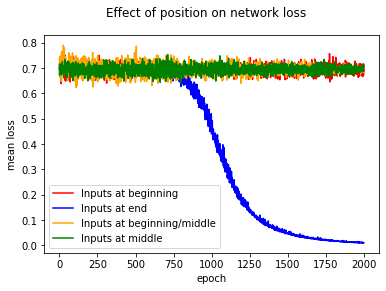

In [30]:
# Testing effect of position on network loss
print("First network: \n")  # inputs placed in the beginning
loss1 = train_network(False, False, input_size, 0, 0, 10)  
print("Second network: \n")  # inputs placed in the end
loss2 = train_network(False, False, input_size, 10, 0, 0)  
print("Third network: \n")  # inputs placed in the beginning and middle
loss3 = train_network(False, False, input_size, 0, 5, 5)  
print("Fourth network: \n")  # inputs placed directly in the middle
loss4 = train_network(False, False, input_size, 5, 0, 5)  

plot_four_losses("Effect of position on network loss", 
                 loss1, loss2, loss3, loss4)
plt.legend(["Inputs at beginning", "Inputs at end", "Inputs at beginning/middle", "Inputs at middle"])

First network: 

Cost at epoch 0 is 0.6736484169960022
Cost at epoch 125 is 0.037941865622997284
Cost at epoch 250 is 0.006181059405207634
Cost at epoch 375 is 0.002679810393601656
Cost at epoch 499 is 0.00150272436439991


Second network: 

Cost at epoch 0 is 0.7019227147102356
Cost at epoch 125 is 0.025000158697366714
Cost at epoch 250 is 0.006096255034208298
Cost at epoch 375 is 0.0027678769547492266
Cost at epoch 499 is 0.0015643927035853267


Third network: 

Cost at epoch 0 is 0.685178279876709
Cost at epoch 125 is 0.03668176382780075
Cost at epoch 250 is 0.007877925410866737
Cost at epoch 375 is 0.0035209907218813896
Cost at epoch 499 is 0.001989512238651514


Fourth network: 

Cost at epoch 0 is 0.7406363487243652
Cost at epoch 125 is 0.020164523273706436
Cost at epoch 250 is 0.005132937338203192
Cost at epoch 375 is 0.0024209143593907356
Cost at epoch 499 is 0.0014033671468496323




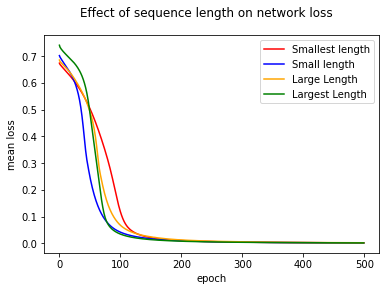

In [21]:
# Testing the effect of sample length on network loss
print("First network: \n")  # smallest
loss5 = train_network(False, False, input_size, 1, 2, 3)  
print("Second network: \n")  # bigger
loss6 = train_network(False, False, input_size, 10, 15, 20)  
print("Third network: \n")  # even bigger
loss7 = train_network(False, False, input_size, 25, 50, 100)  
print("Fourth network: \n")  # largest
loss8 = train_network(False, False, input_size, 50, 100, 200)  

plot_four_losses("Effect of sequence length on network loss", 
                 loss5, loss6, loss7, loss8)
plt.legend(["Smallest length", "Small length", "Large Length", "Largest Length"])

First network: 

Cost at epoch 0 is 0.6930080056190491
Cost at epoch 125 is 0.031836189329624176
Cost at epoch 250 is 0.008736425079405308
Cost at epoch 375 is 0.0038683947641402483
Cost at epoch 499 is 0.0021262727677822113


Second network: 

Cost at epoch 0 is 0.6880412697792053
Cost at epoch 125 is 0.05889465659856796
Cost at epoch 250 is 0.009881204925477505
Cost at epoch 375 is 0.003948944620788097
Cost at epoch 499 is 0.002081648912280798


Third network: 

Cost at epoch 0 is 0.6987992525100708
Cost at epoch 125 is 0.03008095920085907
Cost at epoch 250 is 0.007241261191666126
Cost at epoch 375 is 0.003247633343562484
Cost at epoch 499 is 0.0018057883717119694


Fourth network: 

Cost at epoch 0 is 0.6971030831336975
Cost at epoch 125 is 0.06001216545701027
Cost at epoch 250 is 0.013156529515981674
Cost at epoch 375 is 0.005656954366713762
Cost at epoch 499 is 0.0030967032071202993




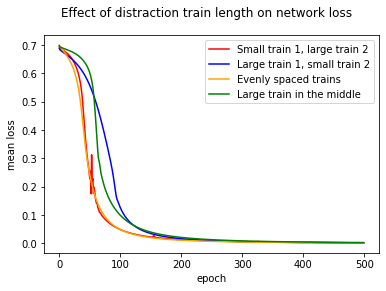

In [ ]:
# Testing effect of distraction train size on network loss w sequence length 50
print("First network: \n")  # smallest first train, large second train
loss9 = train_network(False, False, input_size, 5, 45, 0)  
print("Second network: \n")  # large first train, small second train
loss10 = train_network(False, False, input_size, 45, 5, 0)  
print("Third network: \n")  # evenly spaced trains
loss11 = train_network(False, False, input_size, 25, 25, 0)  
print("Fourth network: \n")  # large train in the middle
loss12 = train_network(False, False, input_size, 0, 50, 0)  

plot_four_losses("Effect of distraction train length on network loss", 
                 loss9, loss10, loss11, loss12)
plt.legend(["Small train 1, large train 2", "Large train 1, small train 2", "Evenly spaced trains", "Large train in the middle"])